In [23]:
# Manipulation de données et calculs
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets et Réduction de dimension
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE

# Préparation et Validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Modèles de Classification
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.cluster import KMeans

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    f1_score
)

is_cat =  False
n_clusters = 4

In [24]:
name = "dataset/cleaned_dataset_v2.csv"
target_col = "Churn"
df = pd.read_csv(name)
df = df.drop(columns=['Unnamed: 0'])

In [25]:
def preparer_donnees_classification(df, target_column='Churn', test_size=0.2, random_state=42, keep_cluster=False):
    # Préparation de la liste des colonnes à supprimer
    del_cols = [target_column,"TotalCharges"]
    
    if not keep_cluster and "Cluster" in df.columns: 
        del_cols.append("Cluster")
    
    # Séparation Features / Target
    X = df.drop(columns=del_cols)
    y = df[target_column]
    
    # Split des données
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [26]:
import joblib

def preparer_donnees_classification_export(df, path_modele_clustering='modele_clustering_telecom.joblib', target_column='Churn_Encoded', test_size=0.2, random_state=42, keep_cluster = True ):
    """
    Utilise un modèle KMeans pré-entraîné pour générer les segments 
    comme caractéristiques de classification.
    """
    del_cols = [target_column]
    # 1. Charger les outils sauvegardés
    artifacts = joblib.load(path_modele_clustering)
    kmeans = artifacts['kmeans_model']
    scaler = artifacts['scaler_cluster']
    variables_cles = artifacts['variables_cles']


    # 1. Nettoyage
    X = df.drop(columns=[target_column,'TotalCharges'])
    y = df[target_column]
    
    # 2. Split (Stratifié pour le multi-classe)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 3. Standardisation (Nécessaire pour les features de base)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # On repasse en DataFrame
    X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
    
    # 4. Application du KMeans déjà entraîné
    # Important : On utilise uniquement les 'variables_cluster' pour prédire le cluster
    X_train_for_cluster = X_train_final[variables_cles]
    X_test_for_cluster = X_test_final[variables_cles]
    
    # Prédire les clusters (0 à 7 selon tes derniers résultats)
    X_train_final['Cluster'] = kmeans.predict(X_train_for_cluster)
    X_test_final['Cluster'] = kmeans.predict(X_test_for_cluster)
    
    # 5. One-Hot Encoding des Segments
    X_train_final = pd.get_dummies(X_train_final, columns=['Cluster'], prefix='Segment')
    X_test_final = pd.get_dummies(X_test_final, columns=['Cluster'], prefix='Segment')
    
    # Aligner les colonnes (au cas où un segment n'est pas représenté dans le test)
    X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)
    
    return X_train_final, X_test_final, y_train, y_test

In [27]:


X = df.drop(columns=[target_col,"TotalCharges"])
y = df[target_col]

X_train, X_test, y_train, y_test = preparer_donnees_classification(df, target_column= target_col, keep_cluster=False)
#X_train, X_test, y_train, y_test = preparer_donnees_classification_export(df, target_column= target_col, keep_cluster=False)

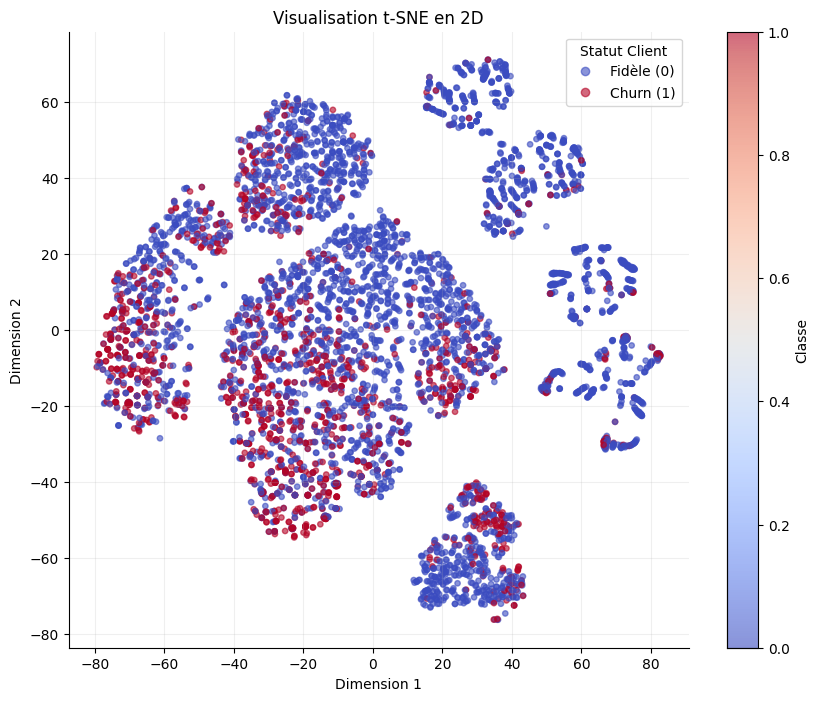

In [28]:
# Visualisation en utilisant t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    init='pca',
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap="coolwarm", s=15,alpha=0.6)
handles, labels = scatter.legend_elements()
if is_cat:
    plt.legend(handles, ["Active (0)", "1-2 mois (1)", "2-10 mois (2)", "10-29 mois (3)", "29-72 mois (4)"], loc="upper right", title="Statut Client")
else:
    plt.legend(handles, ["Fidèle (0)", "Churn (1)"], loc="upper right", title="Statut Client")
plt.colorbar(scatter, label="Classe")
plt.title("Visualisation t-SNE en 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
sns.despine() # Supprime les bordures haut et droite
plt.grid(alpha=0.2) # Ajoute un quadrillage léger
plt.show()


### Modelisation 

In [29]:
param_grids = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {'n_neighbors': [3, 5, 7, 9, 12, 15, 17, 20], 'weights': ['uniform', 'distance']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'max_depth': [None, 5, 10, 15, 20]}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 15, 20]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42, class_weight='balanced'), # AJOUTÉ
        "params": {'C': [0.1, 1, 10], 'kernel': ['rbf']}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, verbose=-1, is_unbalance=True), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 175, 200, 250], 'learning_rate': [0.005, 0.01, 0.1]} #150 et 175
    },
    "XGBoost": {
        # Pour XGBoost, on utilise scale_pos_weight (Ratio Majoritaire/Minoritaire = 80/20 = 4)
        "model": XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4), # AJOUTÉ
        "params": {'n_estimators': [100, 150, 200], 'max_depth': [3, 4, 5, 6]}
    },
        "Gaussian NB": {
        "model": GaussianNB(),
        "params": {} # Pas d'hyperparamètres majeurs à tuner
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }
}

best_estimators = {}

for name, config in param_grids.items():
    print(f"Optimisation de {name}...")
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Meilleurs paramètres : {grid.best_params_}")



Optimisation de KNN...
Meilleurs paramètres : {'n_neighbors': 17, 'weights': 'uniform'}
Optimisation de Decision Tree...
Meilleurs paramètres : {'max_depth': 5}
Optimisation de Logistic Regression...
Meilleurs paramètres : {'C': 1}
Optimisation de Random Forest...
Meilleurs paramètres : {'max_depth': 10, 'n_estimators': 150}
Optimisation de SVM...
Meilleurs paramètres : {'C': 1, 'kernel': 'rbf'}
Optimisation de LightGBM...
Meilleurs paramètres : {'learning_rate': 0.01, 'n_estimators': 175}
Optimisation de XGBoost...
Meilleurs paramètres : {'max_depth': 3, 'n_estimators': 100}
Optimisation de Gaussian NB...
Meilleurs paramètres : {}
Optimisation de AdaBoost...
Meilleurs paramètres : {'learning_rate': 1.0, 'n_estimators': 100}


In [30]:
estimators_list = [
    ('rf', best_estimators["Random Forest"]),
    ('svc', best_estimators["SVM"]),
    ('lr', best_estimators["Logistic Regression"])
]

base_performance = [
    ('xgb',best_estimators["XGBoost"]),  # Votre meilleur XGBoost
    ('lgbm',best_estimators["LightGBM"]) # Votre meilleur LightGBM
]


# --- VERSION B : STACKING "DIVERSITÉ & ROBUSTESSE" ---
base_diversite = [
    ('xgb',best_estimators["XGBoost"]),              # Boosting (Focus sur les erreurs)
    ('rf',best_estimators["Random Forest"]),               # Bagging (Focus sur la variance)
    ('knn',best_estimators["KNN"] ) # Instance-based (Focus sur la proximité locale)
]

# Voting Classifier
voting_clf = VotingClassifier(estimators=estimators_list, voting='soft')
voting_clf.fit(X_train, y_train)
best_estimators["Voting"] = voting_clf

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=estimators_list, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
best_estimators["Stacking"] = stacking_clf

stacking_perf = StackingClassifier(
    estimators=base_performance,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_perf.fit(X_train, y_train)
best_estimators["Stacking_perf"] = stacking_perf

stacking_div= StackingClassifier(
    estimators=base_diversite,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking_div.fit(X_train, y_train)
best_estimators["Stacking_div"] = stacking_div

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

In [31]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

def evaluer_tous_les_modeles_binaires(dict_modeles, X_test, y_test):
    resultats = []

    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)

        # Certaines métriques utilisent les probabilités
        if hasattr(modele, "predict_proba"):
            y_proba = modele.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = None

        # Métriques binaires
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        resultats.append({
            "Modèle": nom,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "ROC-AUC": roc_auc
        })

        # Matrice de confusion pour les modèles clés
        if nom in ["Stacking", "LightGBM", "Random Forest","XGBoost"]:
            plt.figure(figsize=(6, 5))
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(
                cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Non churn (0)', 'Churn (1)'],
                yticklabels=['Non churn (0)', 'Churn (1)']
            )

            plt.title(f"Matrice de confusion – {nom}")
            plt.ylabel("Classe réelle")
            plt.xlabel("Classe prédite")
            plt.show()

    # Tableau récapitulatif
    df_perf = (
        pd.DataFrame(resultats)
        .sort_values(by="F1-score", ascending=False)
        .reset_index(drop=True)
    )

    # Comparaison des modèles (F1-score)
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x="F1-score",
        y="Modèle",
        data=df_perf,
        palette="Blues_r"
    )
    plt.title("Comparaison des modèles – Classification binaire (F1-score)")
    plt.xlim(0, 1)
    plt.show()

    return df_perf


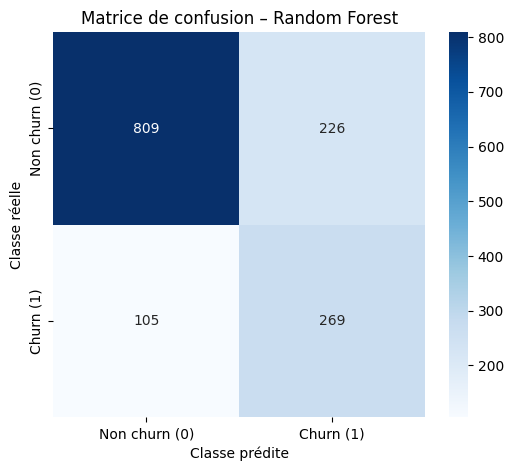

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


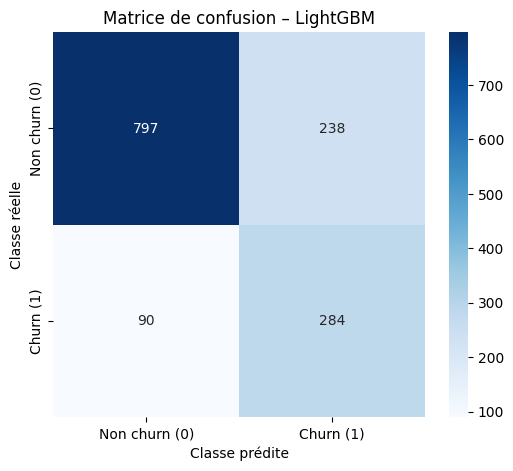

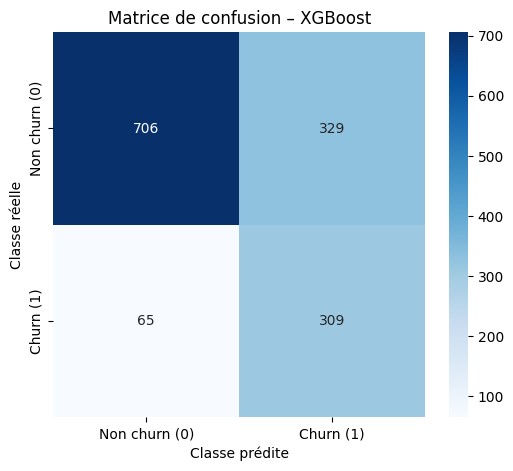

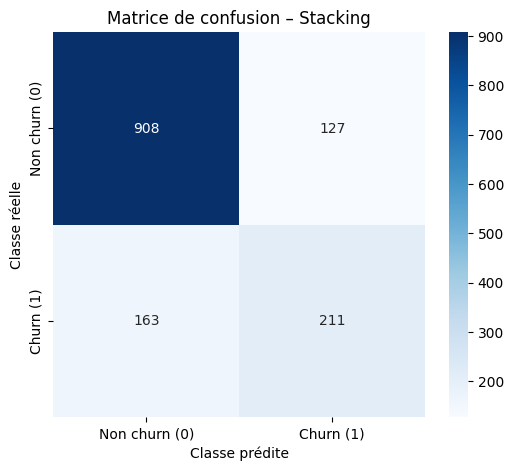

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Local\Temp\ipykernel_20232\2815036628.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


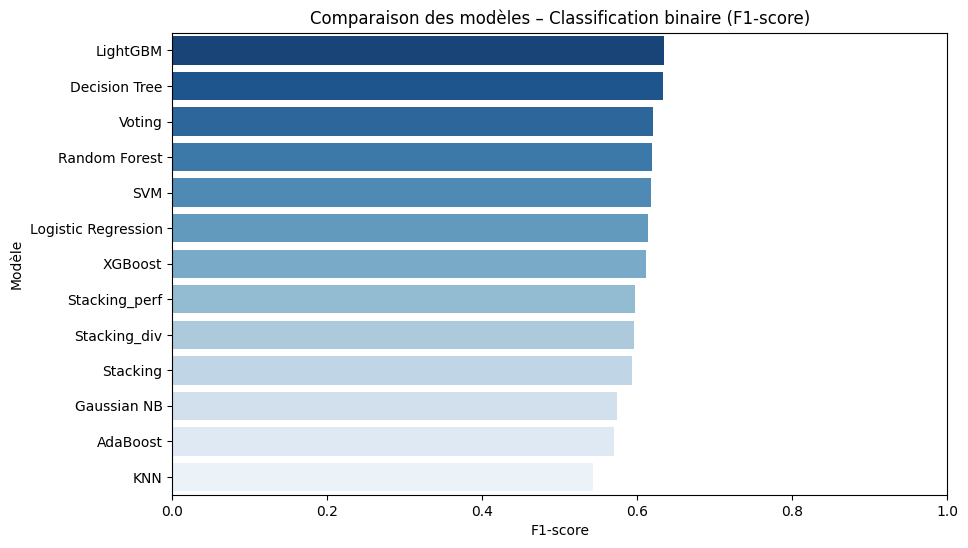

,Modèle,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,LightGBM,0.767211,0.544061,0.759358,0.633929,0.841729
1,Decision Tree,0.756565,0.527629,0.791444,0.633155,0.837432
2,Voting,0.769340,0.550936,0.708556,0.619883,0.839037
3,Random Forest,0.765082,0.543434,0.719251,0.619102,0.836554
4,SVM,0.743790,0.511424,0.778075,0.617179,0.818621
5,Logistic Regression,0.740951,0.507881,0.775401,0.613757,0.838237
6,XGBoost,0.720369,0.484326,0.826203,0.610672,0.834879
7,Stacking_perf,0.796309,0.628319,0.569519,0.597475,0.842252
8,Stacking_div,0.795600,0.627219,0.566845,0.595506,0.837801
9,Stacking,0.794180,0.624260,0.564171,0.592697,0.841091


In [32]:
evaluer_tous_les_modeles_binaires(best_estimators,X_test,y_test)

C:\Users\sppre\AppData\Local\Temp\ipykernel_20232\3262757486.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')


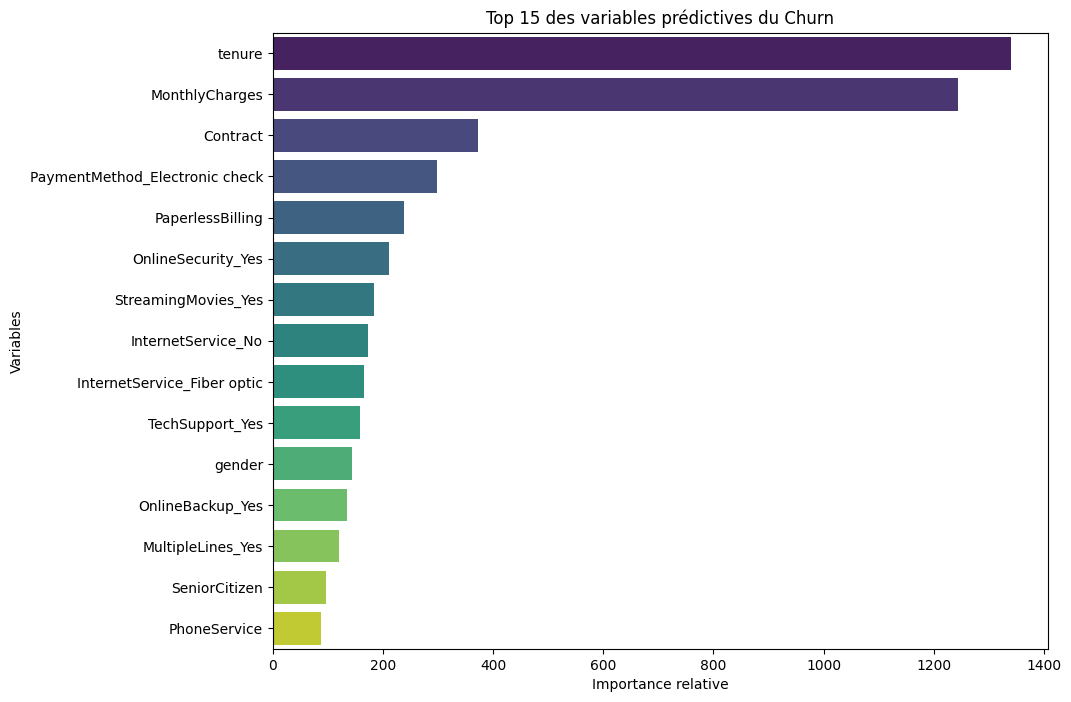

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

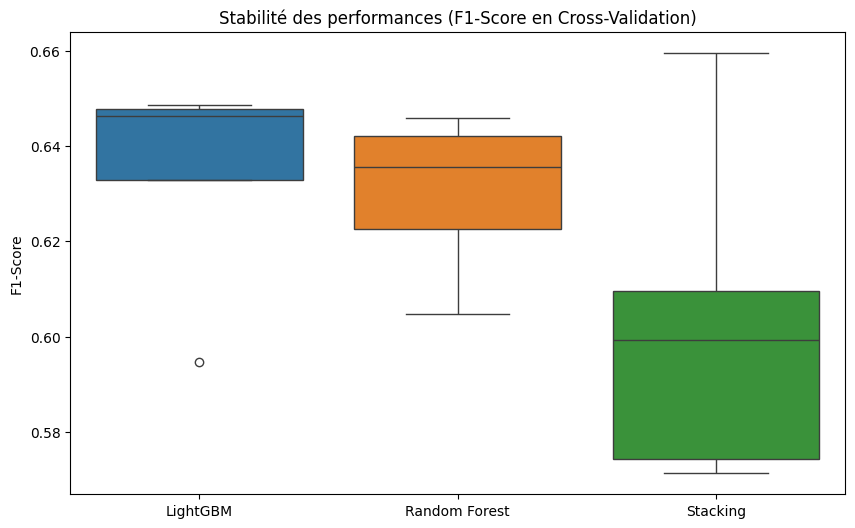

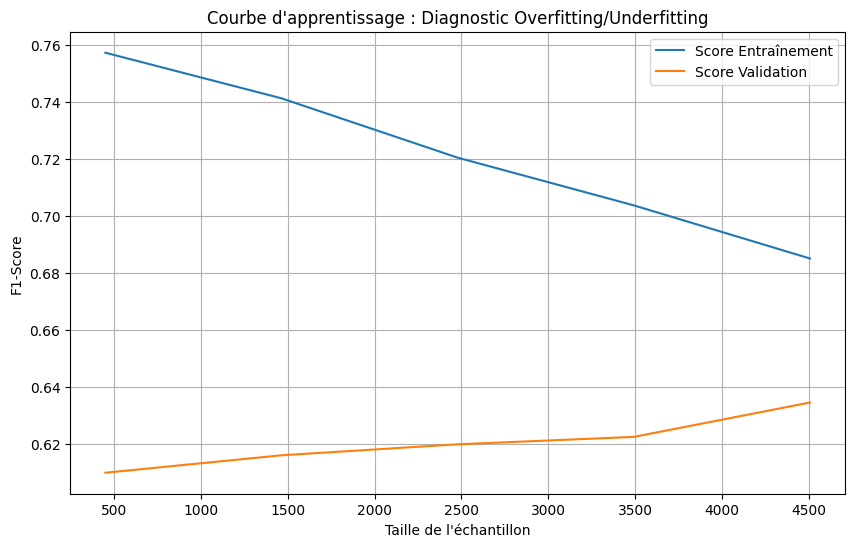

In [33]:
# --- ANALYSE DE L'IMPORTANCE DES VARIABLES ---
importances = best_estimators["LightGBM"].feature_importances_
feature_names = X.columns # Assurez-vous d'avoir gardé les noms de colonnes
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title('Top 15 des variables prédictives du Churn')
plt.xlabel('Importance relative')
plt.ylabel('Variables')
plt.show()

# --- ANALYSE DE LA ROBUSTESSE (CROSS-VALIDATION) ---
cv_results = {}
for name in ["LightGBM", "Random Forest", "Stacking"]:
    scores = cross_val_score(best_estimators[name], X_train, y_train, cv=5, scoring='f1')
    cv_results[name] = scores

cv_df = pd.DataFrame(cv_results)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Stabilité des performances (F1-Score en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

# --- COURBE D'APPRENTISSAGE (LEARNING CURVE) ---
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Score Entraînement')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Score Validation')
plt.title('Courbe d\'apprentissage : Diagnostic Overfitting/Underfitting')
plt.xlabel('Taille de l\'échantillon')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
feature_names

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [35]:
len(importances)

28

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LG

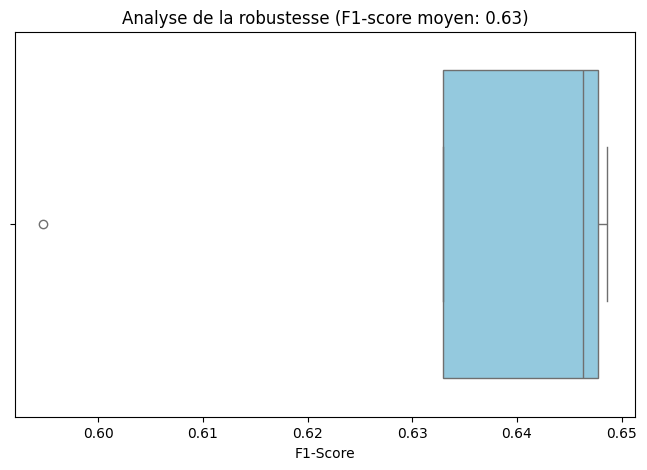

In [36]:
from sklearn.model_selection import cross_val_score

# Calcul des scores sur 5 découpages différents
cv_scores = cross_val_score(best_estimators["LightGBM"], X_train, y_train, cv=5, scoring='f1')

plt.figure(figsize=(8, 5))
sns.boxplot(x=cv_scores, color='skyblue')
plt.title(f'Analyse de la robustesse (F1-score moyen: {cv_scores.mean():.2f})')
plt.xlabel('F1-Score')
plt.show()

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


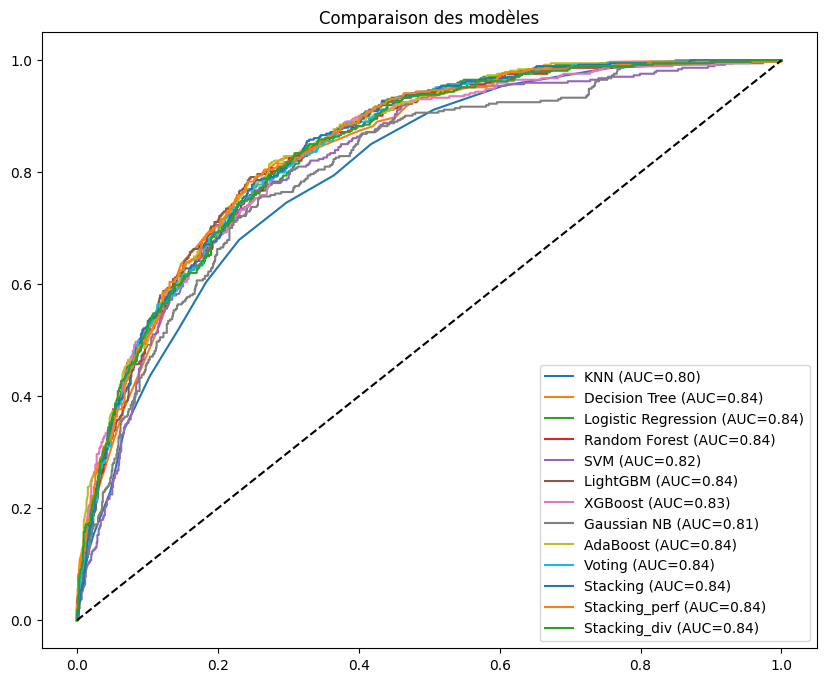

                 Modèle  Accuracy  F1-Score       AUC
5              LightGBM  0.767211  0.633929  0.841729
1         Decision Tree  0.756565  0.633155  0.837432
9                Voting  0.769340  0.619883  0.839037
3         Random Forest  0.765082  0.619102  0.836554
4                   SVM  0.743790  0.617179  0.818621
2   Logistic Regression  0.740951  0.613757  0.838237
6               XGBoost  0.720369  0.610672  0.834879
11        Stacking_perf  0.796309  0.597475  0.842252
12         Stacking_div  0.795600  0.595506  0.837801
10             Stacking  0.794180  0.592697  0.841091
7           Gaussian NB  0.652236  0.573913  0.805557
8              AdaBoost  0.794180  0.569733  0.844190
0                   KNN  0.766501  0.542420  0.800554


In [37]:
def evaluer_tous_les_modeles(dict_modeles, X_test, y_test):
    resultats = []
    plt.figure(figsize=(10, 8))
    
    for nom, modele in dict_modeles.items():
        y_pred = modele.predict(X_test)
        y_prob = modele.predict_proba(X_test)[:, 1] if hasattr(modele, "predict_proba") else y_pred
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        resultats.append({"Modèle": nom, "Accuracy": acc, "F1-Score": f1, "AUC": auc})
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{nom} (AUC={auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.title("Comparaison des modèles")
    plt.show()
    
    return pd.DataFrame(resultats).sort_values(by="F1-Score", ascending=False)

df_perf = evaluer_tous_les_modeles(best_estimators, X_test, y_test)
print(df_perf)

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


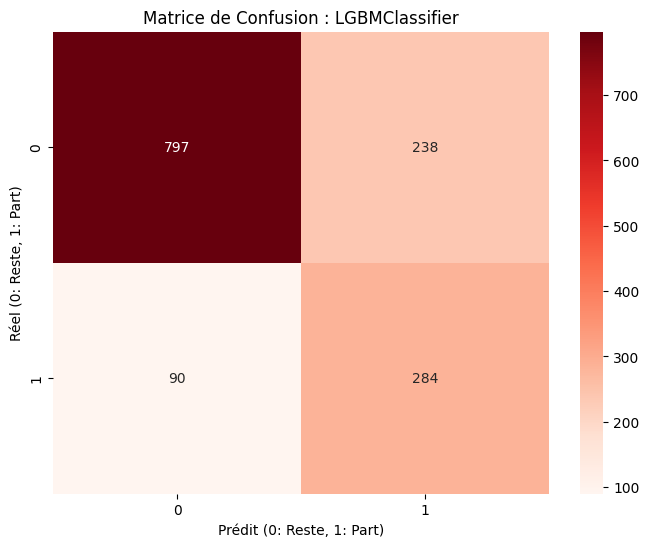

On a raté 90 clients qui sont partis sans qu'on les aide.
On a fait 238 cadeaux inutiles à des clients qui n'allaient pas partir.


In [38]:
from sklearn.metrics import confusion_matrix

# Calcul pour le meilleur modèle (LightGBM)
best_model = best_estimators["LightGBM"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f"Matrice de Confusion : {type(best_model).__name__}")
plt.ylabel('Réel (0: Reste, 1: Part)')
plt.xlabel('Prédit (0: Reste, 1: Part)')
plt.show()

# Analyse métier rapide
fn = cm[1, 0] # Faux Négatifs
fp = cm[0, 1] # Faux Positifs
print(f"On a raté {fn} clients qui sont partis sans qu'on les aide.")
print(f"On a fait {fp} cadeaux inutiles à des clients qui n'allaient pas partir.")

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


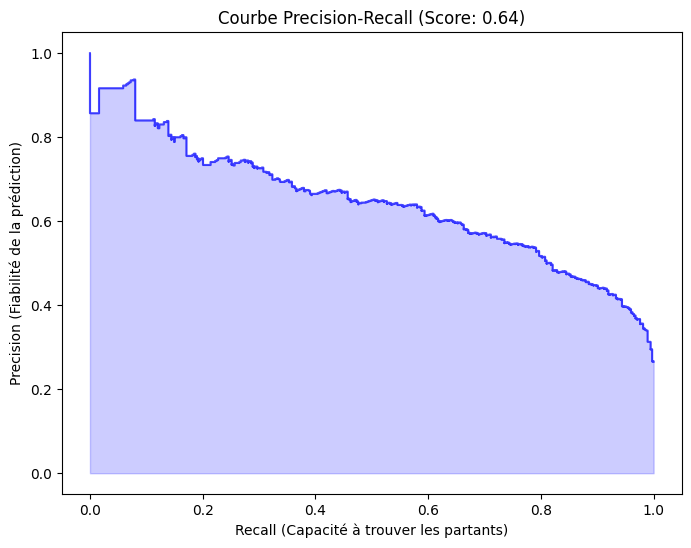

In [39]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_p = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall (Capacité à trouver les partants)')
plt.ylabel('Precision (Fiabilité de la prédiction)')
plt.title(f'Courbe Precision-Recall (Score: {avg_p:.2f})')
plt.show()

On observe le compromis classique (trade-off) entre précision et rappel :

    Zone de haute précision (Début de la courbe) : Pour un rappel très faible (moins de 0.1), la précision est proche de 0.9. Cela signifie que si vous ne ciblez que les cas "évidents", vous ne vous trompez presque jamais.

    La "chute" initiale : On remarque une chute rapide de la précision dès qu'on dépasse 0.1 de rappel. Le modèle perd vite en fiabilité dès qu'il essaie de sortir de sa "zone de confort".

    Le milieu de courbe : Pour attraper 50 % des partants (Recall = 0.5), votre précision tombe à environ 0.65. Cela signifie que pour chaque groupe de personnes que vous identifiez, environ 1/3 d'entre elles sont des "fausses alertes".

    Fin de courbe : Pour capturer 90 % des partants (Recall = 0.9), la précision chute sous 0.4. À ce stade, vous envoyez des alertes à beaucoup de gens qui ne comptent pas partir.